In [1]:
# Notebook setup
import os
import sys

sys.path.append("../")

OUTPUT_DIR = "../outputs"
DATA_DIR = "../vertigorawdata"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def add_bar_labels(ax, decimals=0):
    for container in ax.containers:
        ax.bar_label(
            container,
            labels=[f"{v:.{decimals}f}" for v in container.datavalues],
            label_type="edge",
            padding=3
        )

In [2]:
# Load & Concat Data
from glob import glob

files = sorted(glob(f"{DATA_DIR}/*.csv"))
assert len(files) > 0, "No CSV files found"

df = pd.concat(
    (pd.read_csv(f) for f in files),
    ignore_index=True
)

df["event_date"] = pd.to_datetime(df["event_date"])
df["install_date"] = pd.to_datetime(df["install_date"])

df.shape


(7293526, 14)

In [3]:
# Check daily aggregation level: one row per user per day

daily_counts = (
    df.groupby(["user_id", "event_date"])
      .size()
      .value_counts()
      .sort_index()
)

daily_counts


1    7292216
2        655
Name: count, dtype: int64

In [4]:
# Basic Sanity Checks
sanity = {
    "negative_session_duration": (df["total_session_duration"] < 0).mean(),
    "negative_revenue": ((df["iap_revenue"] < 0) | (df["ad_revenue"] < 0)).mean(),
    "match_end_gt_start": (df["match_end_count"] > df["match_start_count"]).mean()
}

pd.Series(sanity)


negative_session_duration    0.000000
negative_revenue             0.000000
match_end_gt_start           0.006289
dtype: float64

In [5]:
# Install-Day Engagement Segmentation
df["user_age"] = (df["event_date"] - df["install_date"]).dt.days

install_day = df[df["user_age"] == 0].copy()

p25 = install_day["total_session_duration"].quantile(0.333)
p75 = install_day["total_session_duration"].quantile(0.666)

def segment(x):
    if x <= p25:
        return "Low"
    elif x >= p75:
        return "High"
    else:
        return "Mid"

install_day["engagement_segment"] = install_day["total_session_duration"].apply(segment)

segment_map = install_day[["user_id", "engagement_segment"]]
df = df.merge(segment_map, on="user_id", how="left")


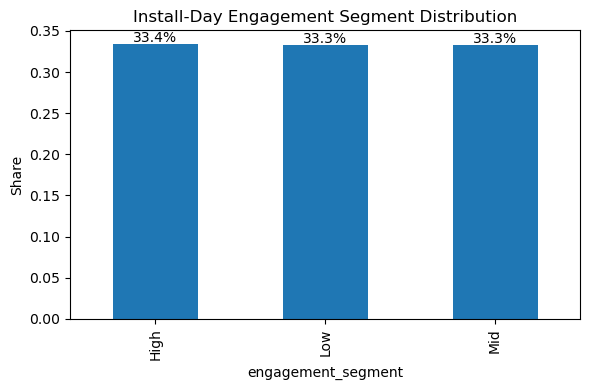

In [6]:
# Segment Distribution
seg_dist = install_day["engagement_segment"].value_counts(normalize=True)

ax = seg_dist.plot(kind="bar", figsize=(6,4))
plt.title("Install-Day Engagement Segment Distribution")
plt.ylabel("Share")

for c in ax.containers:
    ax.bar_label(
        c,
        labels=[f"{v*100:.1f}%" for v in c.datavalues],
        padding=-1
    )

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_segment_distribution.png")
plt.show()


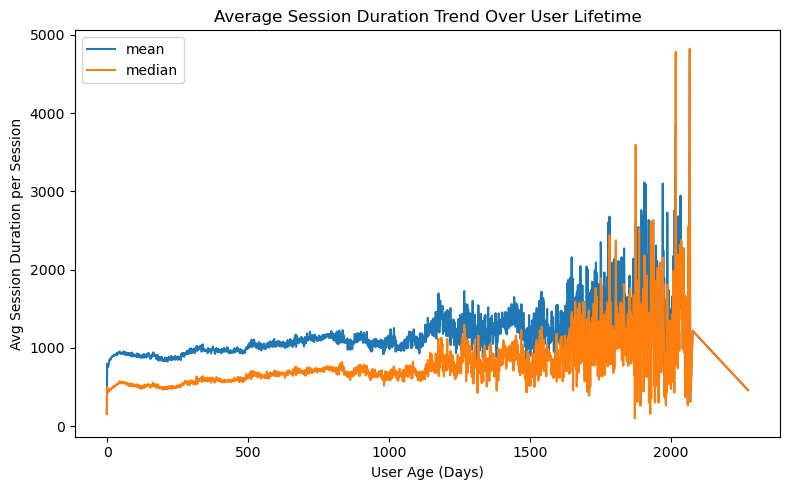

In [7]:
# Average session duration per user-day
df["avg_session_duration"] = (
    df["total_session_duration"] / df["total_session_count"]
)

# Guard against division by zero
df.loc[df["total_session_count"] == 0, "avg_session_duration"] = np.nan

session_trend = (
    df.groupby("user_age")["avg_session_duration"]
      .agg(["mean", "median"])
      .reset_index()
)

ax = session_trend.plot(
    x="user_age",
    y=["mean", "median"],
    figsize=(8, 5)
)

plt.title("Average Session Duration Trend Over User Lifetime")
plt.xlabel("User Age (Days)")
plt.ylabel("Avg Session Duration per Session")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_session_duration_trend.png", bbox_inches="tight")
plt.show()


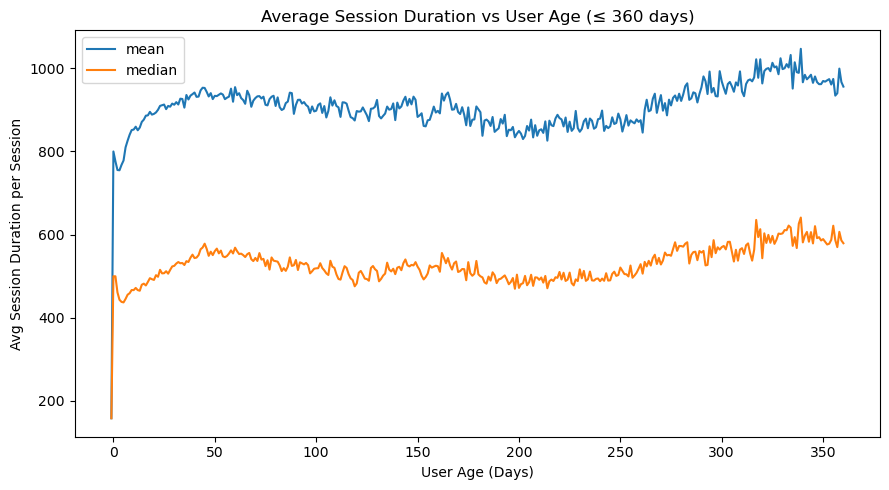

In [8]:
MAX_AGE = 360
df_age_limited = df[df["user_age"] <= MAX_AGE]

session_trend = (
    df_age_limited
    .groupby("user_age")["avg_session_duration"]
    .agg(["mean", "median"])
    .reset_index()
)

ax = session_trend.plot(
    x="user_age",
    y=["mean", "median"],
    figsize=(9,5)
)

plt.title("Average Session Duration vs User Age (≤ 360 days)")
plt.xlabel("User Age (Days)")
plt.ylabel("Avg Session Duration per Session")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_avg_session_duration_age_360.png", bbox_inches="tight")
plt.show()


In [9]:
# Total revenue per user-day
df["total_revenue"] = df["iap_revenue"] + df["ad_revenue"]

# Guard against division by zero
df["win_rate"] = np.where(
    df["match_start_count"] > 0,
    df["victory_count"] / df["match_start_count"],
    np.nan
)

df["completion_rate"] = np.where(
    df["match_start_count"] > 0,
    df["match_end_count"] / df["match_start_count"],
    np.nan
)


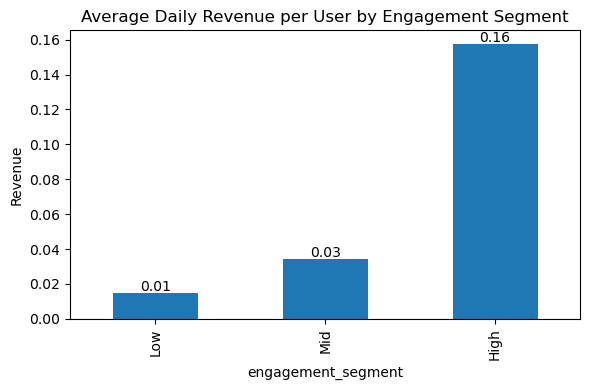

In [10]:
# Revenue by Engagement Segment
df["total_revenue"] = df["iap_revenue"] + df["ad_revenue"]

rev_by_segment = (
    df.groupby("engagement_segment")["total_revenue"]
    .mean()
    .reindex(["Low", "Mid", "High"])
)

ax = rev_by_segment.plot(kind="bar", figsize=(6,4))
plt.title("Average Daily Revenue per User by Engagement Segment")
plt.ylabel("Revenue")

for c in ax.containers:
    ax.bar_label(c, fmt="%.2f", padding=-1)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_revenue_by_segment.png")
plt.show()


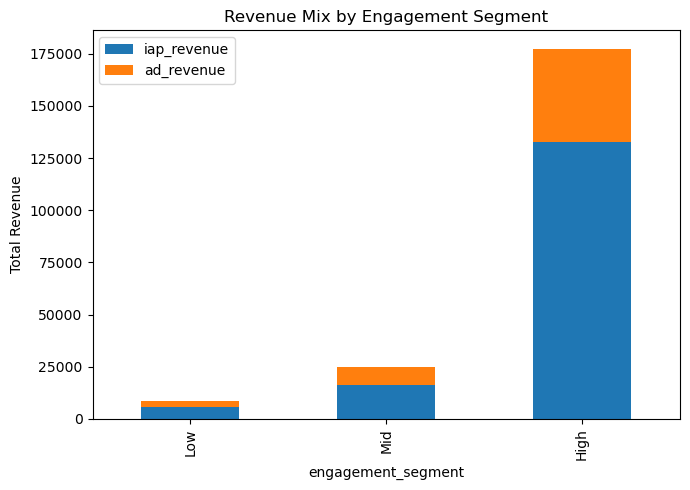

In [11]:
# Revenue Mix (IAP vs Ads)
mix = (
    df.groupby("engagement_segment")[["iap_revenue", "ad_revenue"]]
    .sum()
    .reindex(["Low", "Mid", "High"])
)

ax = mix.plot(kind="bar", stacked=True, figsize=(7,5))
plt.title("Revenue Mix by Engagement Segment")
plt.ylabel("Total Revenue")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_revenue_mix.png")
plt.show()


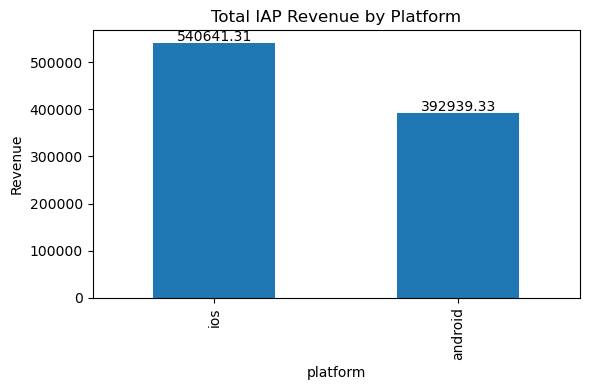

In [12]:
# Platform Comparison 1
platform_rev = (
    df.groupby("platform")["iap_revenue"]
    .sum()
    .sort_values(ascending=False)
)

ax = platform_rev.plot(kind="bar", figsize=(6,4))
plt.title("Total IAP Revenue by Platform")
plt.ylabel("Revenue")

for c in ax.containers:
    ax.bar_label(c, fmt="%.2f", padding=-1)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_platform_comparison_iap.png")
plt.show()

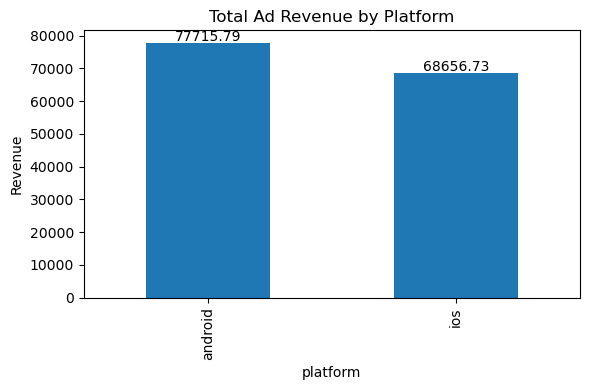

In [13]:
# Platform Comparison 2
platform_rev = (
    df.groupby("platform")["ad_revenue"]
    .sum()
    .sort_values(ascending=False)
)

ax = platform_rev.plot(kind="bar", figsize=(6,4))
plt.title("Total Ad Revenue by Platform")
plt.ylabel("Revenue")

for c in ax.containers:
    ax.bar_label(c, fmt="%.2f", padding=-1)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_platform_comparison_ad.png")
plt.show()

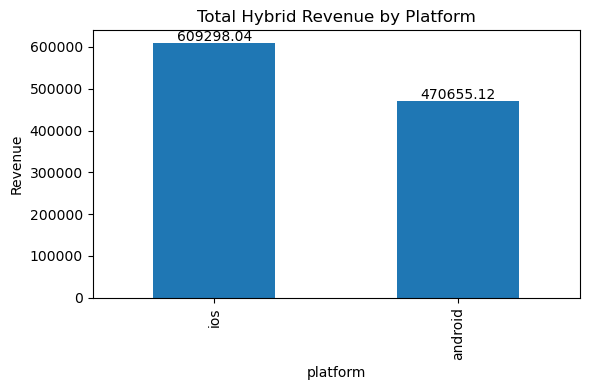

In [14]:
# Platform Comparison 3
platform_rev = (
    df.groupby("platform")["total_revenue"]
    .sum()
    .sort_values(ascending=False)
)

ax = platform_rev.plot(kind="bar", figsize=(6,4))
plt.title("Total Hybrid Revenue by Platform")
plt.ylabel("Revenue")

for c in ax.containers:
    ax.bar_label(c, fmt="%.2f", padding=-1)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_platform_comparison_hybrid.png")
plt.show()


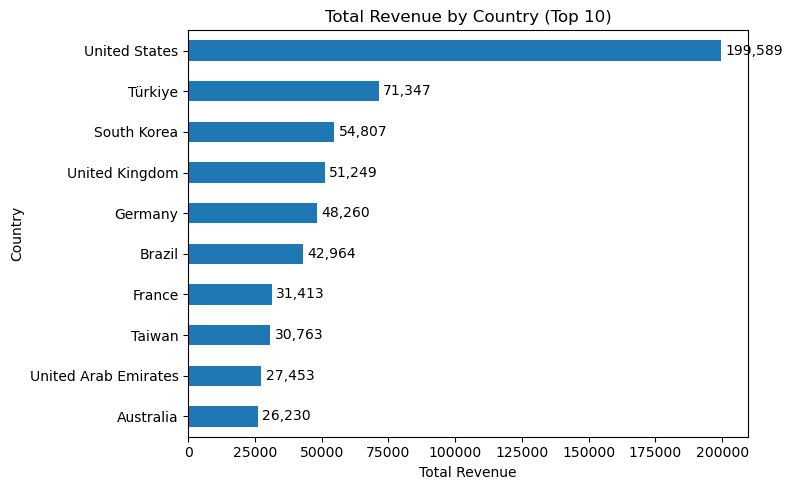

In [15]:
top10_countries = (
    df.groupby("country")["total_revenue"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

top10_countries_plot = top10_countries.sort_values(ascending=True)

ax = top10_countries_plot.plot(
    kind="barh",
    figsize=(8,5)
)

plt.title("Total Revenue by Country (Top 10)")
plt.xlabel("Total Revenue")
plt.ylabel("Country")

for c in ax.containers:
    ax.bar_label(
        c,
        labels=[f"{v:,.0f}" for v in c.datavalues],
        label_type="edge",
        padding=3
    )

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_top_rev_countries.png", bbox_inches="tight")
plt.show()


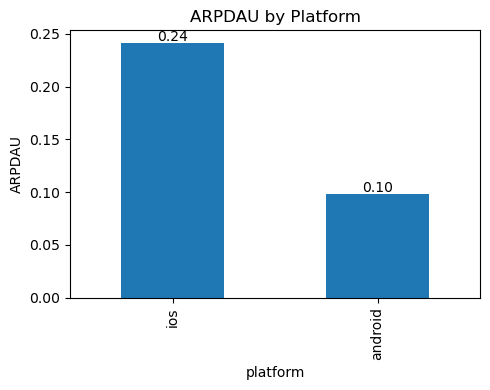

In [16]:
arpdau_platform = (
    df.groupby("platform")["total_revenue"]
      .mean()
      .sort_values(ascending=False)
)

ax = arpdau_platform.plot(kind="bar", figsize=(5,4))
plt.title("ARPDAU by Platform")
plt.ylabel("ARPDAU")

for c in ax.containers:
    ax.bar_label(c, fmt="%.2f", padding=-1)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_arpdau_platform.png")
plt.show()


In [17]:
# Users with at least 7 days of observation
event_window_start = df["event_date"].min()
event_window_end = df["event_date"].max()

eligible_users_7d = (
    df.groupby("user_id")[["install_date", "event_date"]]
      .agg(
          install_date=("install_date", "min"),
          max_event_date=("event_date", "max")
      )
      .loc[
          lambda x:
              (x["install_date"] >= event_window_start) &
              (x["install_date"] <= event_window_end - pd.Timedelta(days=7)) &
              (x["install_date"] <= x["max_event_date"])
      ]
      .index
)

len(eligible_users_7d)


894416

In [18]:
# Eligible cohort already defined as eligible_users_7d

country_map = (
    df[["user_id", "country"]]
    .drop_duplicates()
    .set_index("user_id")
)

eligible_country = (
    pd.Series(eligible_users_7d, name="user_id")
      .to_frame()
      .join(country_map, on="user_id")
)


In [19]:
top50_countries = (
    eligible_country["country"]
    .value_counts()
    .head(50)
    .index
)

top50_countries


Index(['Brazil', 'Türkiye', 'Russia', 'United States', 'Vietnam', 'India',
       'Ukraine', 'Indonesia', 'Philippines', 'Argentina', 'Kazakhstan',
       'Malaysia', 'Germany', 'Mexico', 'Thailand', 'France', 'Uzbekistan',
       'Romania', 'Poland', 'United Kingdom', 'Peru', 'Spain', 'Saudi Arabia',
       'Italy', 'Belarus', 'Venezuela', 'Chile', 'Pakistan', 'Israel',
       'Taiwan', 'Canada', 'Colombia', 'Hungary', 'Azerbaijan', 'South Korea',
       'Czechia', 'Netherlands', 'Bulgaria', 'Iraq', 'Egypt', 'Kyrgyzstan',
       'Belgium', 'Georgia', 'Portugal', 'Australia', 'Algeria', 'Mongolia',
       'Cambodia', 'Serbia', 'China'],
      dtype='object', name='country')

In [20]:
# LTV1 / LTV3 / LTV7 (User-level)
def compute_ltv_window(users, days):
    return (
        df[(df["user_id"].isin(users)) & (df["user_age"] <= days)]
        .groupby("user_id")["total_revenue"]
        .sum()
    )

ltv1 = compute_ltv_window(eligible_users_7d, 1)
ltv3 = compute_ltv_window(eligible_users_7d, 3)
ltv7 = compute_ltv_window(eligible_users_7d, 7)



In [21]:
platform_map = (
    df[["user_id", "platform"]]
    .drop_duplicates()
    .set_index("user_id")
)

ltv_platform = pd.DataFrame({
    "LTV1": ltv1,
    "LTV3": ltv3,
    "LTV7": ltv7
}).join(platform_map)

ltv_platform_summary = (
    ltv_platform
    .groupby("platform")[["LTV1", "LTV3", "LTV7"]]
    .mean()
)

ltv_platform_summary


,LTV1,LTV3,LTV7
platform,,,
android,0.047597,0.067966,0.098227
ios,0.141241,0.217253,0.314156


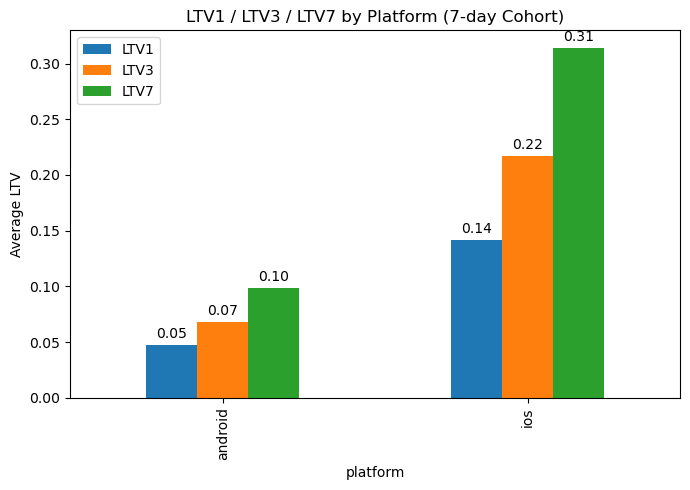

In [22]:
ax = ltv_platform_summary.plot(
    kind="bar",
    figsize=(7,5),
    title="LTV1 / LTV3 / LTV7 by Platform (7-day Cohort)"
)

for c in ax.containers:
    ax.bar_label(c, fmt="%.2f", padding=3)

plt.ylabel("Average LTV")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_ltv_platform_1_3_7.png", bbox_inches="tight")
plt.show()


In [23]:
country_map = (
    df[["user_id", "country"]]
    .drop_duplicates()
    .set_index("user_id")
)

ltv_country = (
    pd.DataFrame({
        "LTV1": ltv1,
        "LTV3": ltv3,
        "LTV7": ltv7
    })
    .join(country_map)
)

ltv_country_top50 = ltv_country[
    ltv_country["country"].isin(top50_countries)
]

ltv_country_summary = (
    ltv_country_top50
    .groupby("country")[["LTV1", "LTV3", "LTV7"]]
    .mean()
)

top10_ltv_countries = (
    ltv_country_summary
    .sort_values("LTV7", ascending=False)
    .head(10)
)

top10_ltv_countries


,LTV1,LTV3,LTV7
country,,,
South Korea,1.171306,1.517081,2.229065
Taiwan,0.488518,0.702654,0.922410
Australia,0.353107,0.460137,0.631068
United States,0.300747,0.441497,0.614010
Canada,0.251970,0.377241,0.523480
United Kingdom,0.181689,0.272918,0.432946
Netherlands,0.128698,0.257459,0.421764
Italy,0.096874,0.224082,0.383706
Belgium,0.140419,0.200524,0.300301


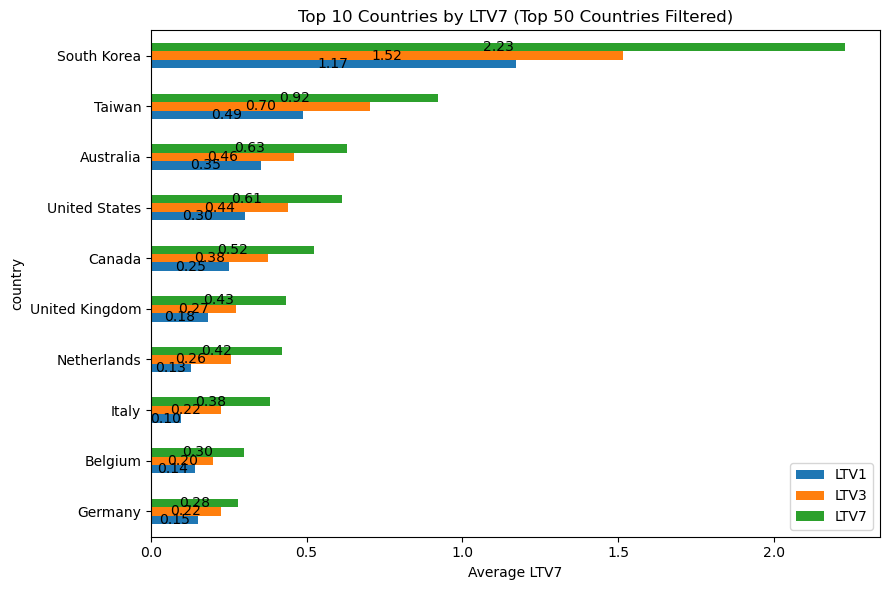

In [24]:
ltv_plot = top10_ltv_countries.sort_values("LTV7", ascending=True)

ax = ltv_plot.plot(
    kind="barh",
    figsize=(9,6),
    title="Top 10 Countries by LTV7 (Top 50 Countries Filtered)"
)

for c in ax.containers:
    ax.bar_label(
        c,
        labels=[f"{v:.2f}" for v in c.datavalues],
        label_type="center"
    )

plt.xlabel("Average LTV7")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_top10_ltv7_countries_top50.png", bbox_inches="tight")
plt.show()


In [25]:
# Check if user has activity on a specific day
def compute_retention(users, day):
    active_users = df[
        (df["user_id"].isin(users)) & (df["user_age"] == day)
    ]["user_id"].unique()

    return pd.Series(
        users.isin(active_users),
        index=users,
        name=f"RET{day}"
    ).astype(int)

ret1 = compute_retention(eligible_users_7d, 1)
ret3 = compute_retention(eligible_users_7d, 3)
ret7 = compute_retention(eligible_users_7d, 7)


In [26]:
platform_map = (
    df[["user_id", "platform"]]
    .drop_duplicates()
    .set_index("user_id")
)

ret_platform = pd.DataFrame({
    "RET1": ret1,
    "RET3": ret3,
    "RET7": ret7
}).join(platform_map)

ret_platform_summary = (
    ret_platform
    .groupby("platform")[["RET1", "RET3", "RET7"]]
    .mean()
)

ret_platform_summary


,RET1,RET3,RET7
platform,,,
android,0.403497,0.137361,0.07121
ios,0.418073,0.157848,0.09112


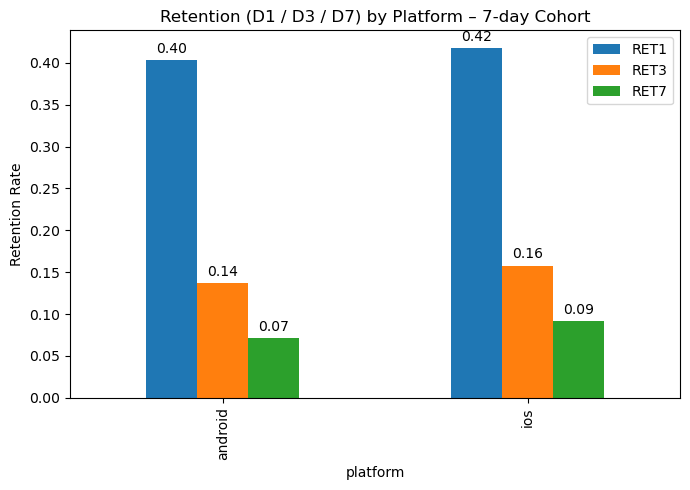

In [27]:
ax = ret_platform_summary.plot(
    kind="bar",
    figsize=(7,5),
    title="Retention (D1 / D3 / D7) by Platform – 7-day Cohort"
)

for c in ax.containers:
    ax.bar_label(c, fmt="%.2f", padding=3)

plt.ylabel("Retention Rate")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_retention_platform_1_3_7.png", bbox_inches="tight")
plt.show()


In [28]:
country_map = (
    df[["user_id", "country"]]
    .drop_duplicates()
    .set_index("user_id")
)

ret_country = (
    pd.DataFrame({
        "RET1": ret1,
        "RET3": ret3,
        "RET7": ret7
    })
    .join(country_map)
)

ret_country_top50 = ret_country[
    ret_country["country"].isin(top50_countries)
]

ret_country_summary = (
    ret_country_top50
    .groupby("country")[["RET1", "RET3", "RET7"]]
    .mean()
)

top10_ret_countries = (
    ret_country_summary
    .sort_values("RET7", ascending=False)
    .head(10)
)

top10_ret_countries


,RET1,RET3,RET7
country,,,
Serbia,0.481745,0.184406,0.099629
Egypt,0.441526,0.167885,0.096391
United Kingdom,0.484628,0.165186,0.094815
Italy,0.447491,0.161338,0.094550
Israel,0.391342,0.164271,0.093087
Poland,0.450525,0.163437,0.092193
Bulgaria,0.431644,0.156243,0.091508
Belgium,0.412509,0.156362,0.090714
Algeria,0.416276,0.150468,0.090164


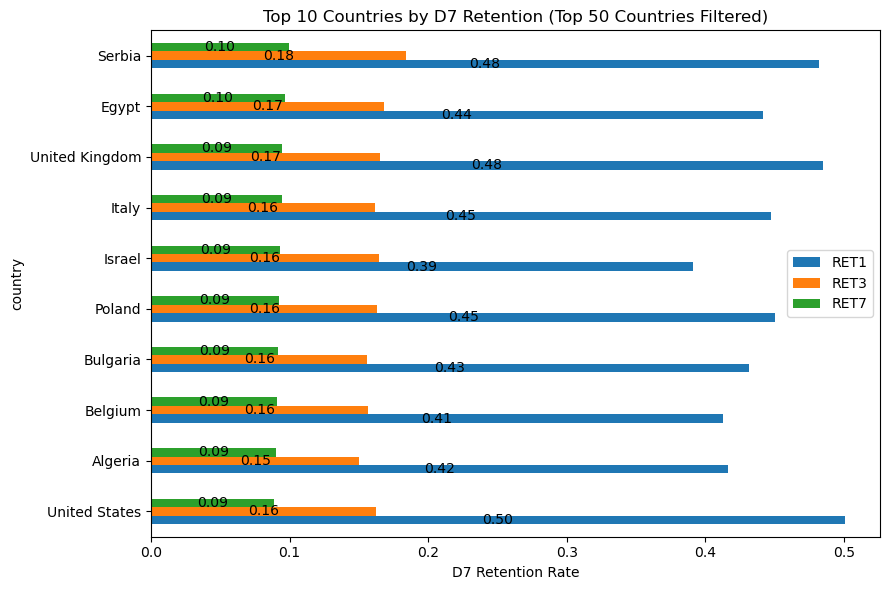

In [29]:
ret_plot = top10_ret_countries.sort_values("RET7", ascending=True)

ax = ret_plot.plot(
    kind="barh",
    figsize=(9,6),
    title="Top 10 Countries by D7 Retention (Top 50 Countries Filtered)"
)

for c in ax.containers:
    ax.bar_label(
        c,
        labels=[f"{v:.2f}" for v in c.datavalues],
        label_type="center"
    )

plt.xlabel("D7 Retention Rate")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_top10_ret7_countries_top50.png", bbox_inches="tight")
plt.show()


In [30]:
# Derived metrics
df["win_rate"] = np.where(
    df["match_start_count"] > 0,
    df["victory_count"] / df["match_start_count"],
    np.nan
)

df["completion_rate"] = np.where(
    df["match_start_count"] > 0,
    df["match_end_count"] / df["match_start_count"],
    np.nan
)

# userAge filtering for shorter & more detailed plots
MAX_AGE = 360
df_age_limited = df[df["user_age"] <= MAX_AGE]


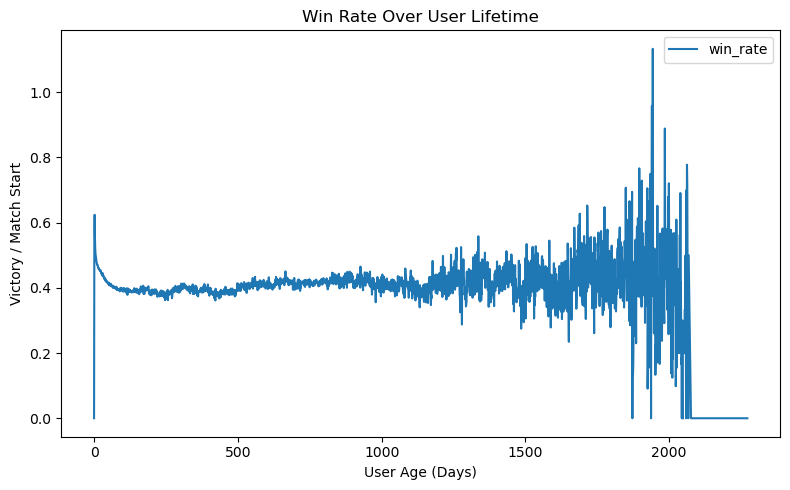

In [31]:
winrate_trend = (
    df.groupby("user_age")["win_rate"]
      .mean()
      .reset_index()
)

ax = winrate_trend.plot(
    x="user_age",
    y="win_rate",
    figsize=(8,5)
)

plt.title("Win Rate Over User Lifetime")
plt.xlabel("User Age (Days)")
plt.ylabel("Victory / Match Start")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_winrate_trend.png")
plt.show()


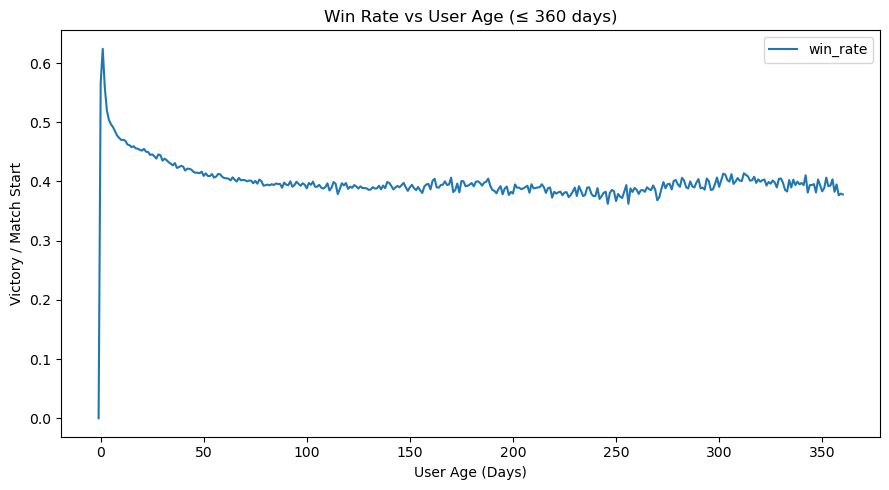

In [32]:
winrate_trend = (
    df_age_limited
    .groupby("user_age")["win_rate"]
    .mean()
    .reset_index()
)

ax = winrate_trend.plot(
    x="user_age",
    y="win_rate",
    figsize=(9,5)
)

plt.title("Win Rate vs User Age (≤ 360 days)")
plt.xlabel("User Age (Days)")
plt.ylabel("Victory / Match Start")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_winrate_age_360.png", bbox_inches="tight")
plt.show()


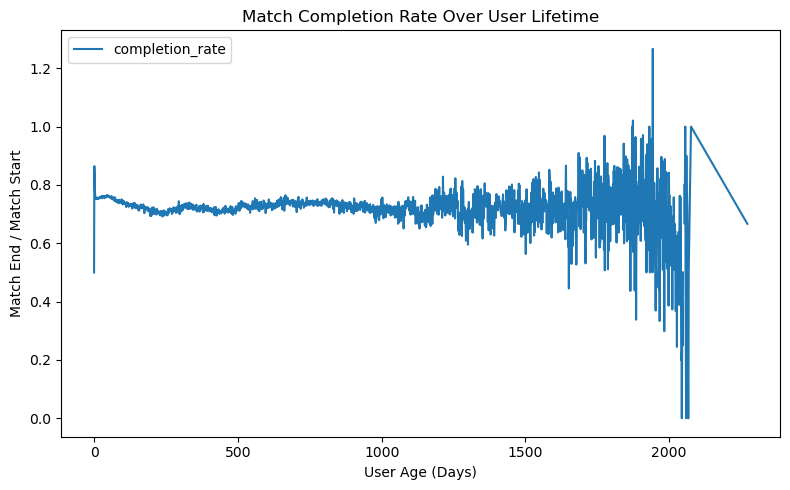

In [33]:
completion_trend = (
    df.groupby("user_age")["completion_rate"]
      .mean()
      .reset_index()
)

ax = completion_trend.plot(
    x="user_age",
    y="completion_rate",
    figsize=(8,5)
)

plt.title("Match Completion Rate Over User Lifetime")
plt.xlabel("User Age (Days)")
plt.ylabel("Match End / Match Start")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_completion_rate_trend.png")
plt.show()


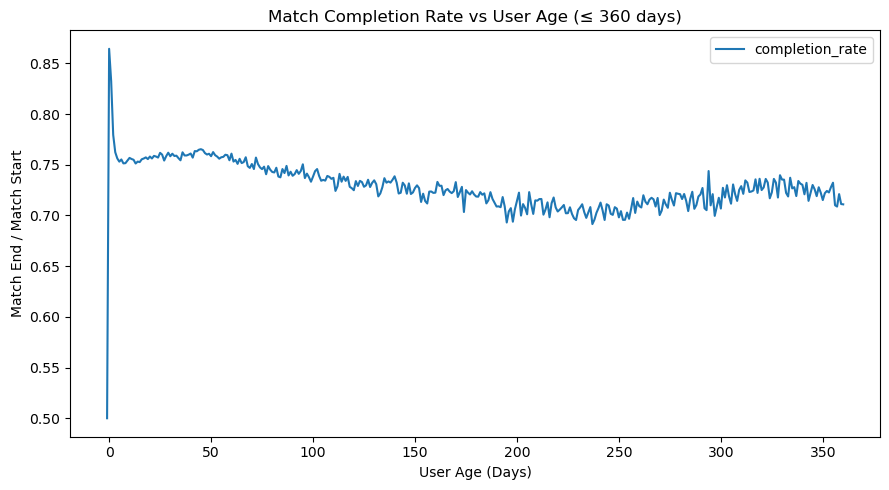

In [34]:
completion_trend = (
    df_age_limited
    .groupby("user_age")["completion_rate"]
    .mean()
    .reset_index()
)

ax = completion_trend.plot(
    x="user_age",
    y="completion_rate",
    figsize=(9,5)
)

plt.title("Match Completion Rate vs User Age (≤ 360 days)")
plt.xlabel("User Age (Days)")
plt.ylabel("Match End / Match Start")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_completion_rate_age_360.png", bbox_inches="tight")
plt.show()


In [35]:
# Only paying users (IAP > 0)
daily_arppu = (
    df[df["iap_revenue"] > 0]
    .groupby("event_date")
    .agg(
        total_iap_revenue=("iap_revenue", "sum"),
        paying_users=("user_id", "nunique")
    )
)

daily_arppu["ARPPU"] = (
    daily_arppu["total_iap_revenue"] / daily_arppu["paying_users"]
)

daily_arppu


,total_iap_revenue,paying_users,ARPPU
event_date,,,
2024-02-15,32488.929477,3500,9.282551
2024-02-16,35780.953622,3585,9.980740
2024-02-17,39786.767930,3203,12.421720
2024-02-18,36599.322077,3084,11.867484
2024-02-19,27582.213425,2724,10.125629
2024-02-20,29855.150344,2659,11.227962
2024-02-21,29223.337725,2542,11.496199
2024-02-22,29742.781245,2586,11.501462
2024-02-23,32441.584242,3321,9.768619


In [36]:
avg_arppu_29d = daily_arppu["ARPPU"].mean()
avg_arppu_29d


np.float64(11.237863951168103)